# A/B-тестирование - новая механика оплаты услуг на сайте
<br>В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 
<br>Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from io import BytesIO
import requests
from urllib.parse import urlencode
import pingouin as pg

C:\Users\Irina\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Irina\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Для начала загрузим данные

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [3]:
public_key = 'https://disk.yandex.by/d/oT80DgG8RkpU_A'  # Сюда вписываю мою ссылку

# Получаю загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаю файл и сохраняю его
r = requests.get(download_url)
data = r.content
groups = pd.read_csv(BytesIO(data), sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# проверим размерность
groups.shape

(74484, 2)

In [5]:
public_key_2 = 'https://disk.yandex.by/d/Z4YT1JTWk8Crtg'  # Сюда вписываю мою ссылку

# Получаю загрузочную ссылку
final_url_2 = base_url + urlencode(dict(public_key=public_key_2))
response2 = requests.get(final_url_2)
download_url_2 = response2.json()['href']

# Загружаю файл и сохраняю его
r2 = requests.get(download_url_2)
data_2 = r2.content
active_studs = pd.read_csv(BytesIO(data_2))
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
# проверим размерность
active_studs.shape

(8341, 1)

In [7]:
public_key_3 = 'https://disk.yandex.by/d/uGPe18u1s3nrHw'  # Сюда вписываю мою ссылку

# Получаю загрузочную ссылку
final_url_3 = base_url + urlencode(dict(public_key=public_key_3))
response3 = requests.get(final_url_3)
download_url_3 = response3.json()['href']

# Загружаю файл и сохраняю его
r3 = requests.get(download_url_3)
data_3 = r3.content
checks = pd.read_csv(BytesIO(data_3), sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [8]:
# проверим размерность
checks.shape

(541, 2)

In [9]:
public_key_4 = 'https://disk.yandex.by/d/WjWYC6mFUBDYOA'  # Сюда вписываю мою ссылку

# Получаю загрузочную ссылку
final_url_4 = base_url + urlencode(dict(public_key=public_key_4))
response4 = requests.get(final_url_4)
download_url_4 = response4.json()['href']

# Загружаю файл и сохраняю его
r4 = requests.get(download_url_4)
data_4 = r4.content
groups_add = pd.read_csv(BytesIO(data_4), sep=',')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [10]:
# проверим размерность
groups_add.shape

(92, 2)

Проверим типы данных

In [11]:
groups.dtypes

id      int64
grp    object
dtype: object

In [12]:
active_studs.dtypes

student_id    int64
dtype: object

In [13]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [14]:
groups_add.dtypes

id      int64
grp    object
dtype: object

Вывод: конвертировать типы данных не надо.

Объединим датафреймы *groups* и *groups_add*.

In [15]:
groups = pd.concat([groups, groups_add])
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [16]:
groups.dtypes

id      int64
grp    object
dtype: object

Создадим колонку с признаком активности в датафрейме *groups*. Данные по активности берем из датафрейма *active_studs*.

In [17]:
groups['is_active'] = groups['id'].isin(active_studs.student_id).astype(int)

In [18]:
# проверим
groups.head()

,id,grp,is_active
0,1489,B,0
1,1627,A,1
2,1768,B,0
3,1783,B,0
4,1794,A,0


Теперь можно объединить датафрейм *groups* и *checks*.
<br>Для этого используем LEFT JOIN, т.к. нам нужны все данные из первой таблицы, а оплата может быть осуществлена не всеми пользователями.

In [19]:
all_data = groups.rename(columns={'id' : 'student_id'}).merge(checks, how='left', on='student_id')

In [20]:
# проверим на пустые значения
all_data.isna().sum()

student_id        0
grp               0
is_active         0
rev           74035
dtype: int64

In [21]:
# заменим пустые значения в столбце 'rev' на 0
all_data['rev'] = all_data.rev.fillna(0)

In [22]:
all_data.head()

,student_id,grp,is_active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


In [23]:
# проверим размерность
all_data.shape

(74576, 4)

Посчитаем количество уникальных пользователей в группах А и В

In [24]:
all_data.groupby('grp', as_index=False).agg({'student_id' : 'nunique'})

,grp,student_id
0,A,14693
1,B,59883


Т.к. нас интересуют результаты поведения пользователей только в период проведения эксперимента, удалим из датафрейма данные по пользователям, которые в нем не участвовали.

In [25]:
active_data = all_data.query("is_active == 1")
active_data.head()

,student_id,grp,is_active,rev
1,1627,A,1,990.0
10,2085,B,1,0.0
12,2215,B,1,0.0
43,3391,A,1,0.0
45,3401,B,1,0.0


In [26]:
# проверим новую размерность
active_data.shape

(8341, 4)

In [27]:
# проверим, есть ли повторяющиеся id пользователей (student_id) в контрольной и тестовой группах
res = [x for x in list(active_data[active_data.grp == 1].student_id) if x in list(active_data[active_data.group == 0].student_id)]
len(res)

0

Вывод: один и тот же пользователь не попал в обе группы. Результаты теста могут быть корректны.

Посчитаем количество уникальных пользователей в группах А и В в датафрейме с данными по пользователям, которые участвовали в эксперименте. 

In [28]:
active_data.groupby('grp', as_index=False).agg({'student_id' : 'nunique'})

,grp,student_id
0,A,1538
1,B,6803


Прежде, чем приступить к анализу эффективности внедрения новой механики оплаты услуг на сайте, необходимо определить метрики, по которым будем это оценивать.

Предлагается использовать следующие **метрики**:
- средний доход на пользователя (**ARPU**)
- количество платящих пользователей
- средний доход на платящего пользователя (**ARPPU**)

Анализ **ARPU**

In [29]:
data_revenue = active_data.groupby(['grp', 'student_id'], as_index=False)\
    .agg({'rev' : 'sum'})
data_revenue.head()

,grp,student_id,rev
0,A,1627,990.0
1,A,3391,0.0
2,A,109623,0.0
3,A,133678,0.0
4,A,175944,0.0


In [30]:
# посмотрим значения среднего дохода в контрольной и тестовой группах
data_revenue.groupby('grp', as_index=False).agg({'rev' : 'mean'})

,grp,rev
0,A,47.347204
1,B,58.058798


Видим, что средний доход в тестовой группе больше.

Посмотрим описательные статистики по группам

In [31]:
# контрольная группа A
data_revenue.query("grp == 'A'").rev.describe()

count    1538.000000
mean       47.347204
std       290.490632
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [32]:
# тестовая группа B
data_revenue.query("grp == 'B'").rev.describe()

count    6803.000000
mean       58.058798
std       313.770201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

Кроме роста среднего дохода, мы можем видеть, что и максимальное значение ARPU в тестовой группе выросло.

Визуализируем данные

In [33]:
sns.set(rc={"figure.figsize":(11, 7)})
sns.set_style("whitegrid")

In [34]:
print(sns.__version__)

0.12.2


C:\Users\Irina\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Irina\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Irina\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Irina\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='rev', ylabel='Count'>

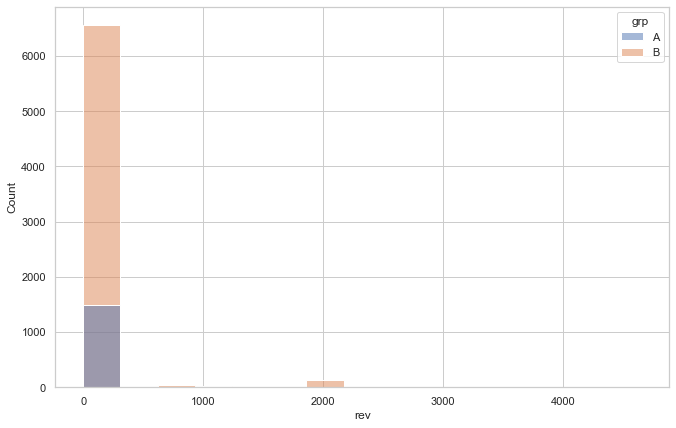

In [35]:
sns.histplot(data=data_revenue, x='rev', hue='grp')

Видим, что наибольшее количество пользователей не оплачивали услуги на сайте.
<br>При этом данный вид графика не нагляден для наших данных.
<br>Поэтому построим боксплот.

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

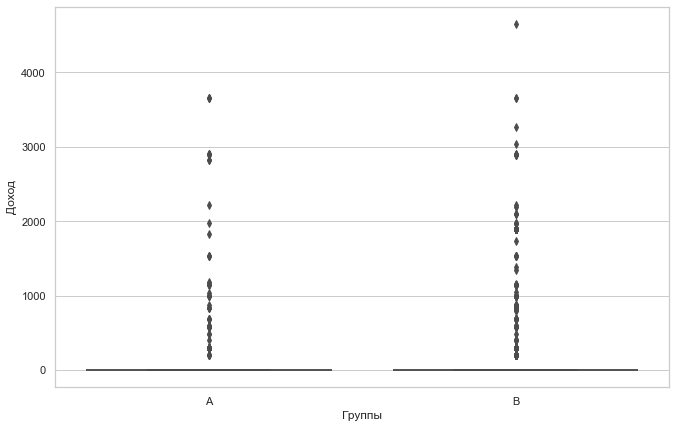

In [36]:
ax = sns.boxplot(x='grp', y='rev', data=data_revenue)
ax.set(xlabel='Группы', ylabel='Доход')
sns.despine

На данном графике мы уже видим разброс значений дохода пользователей.

Ну и теперь можно перейти к проверке статистической значимости результатов. 

Сформулируем гипотезы:
<br>**H0** - эффекта от внедрения новой механики оплаты услуг на сайте нет, изменение среднего дохода пользователя обусловлено другими факторами
<br>**H1** - внедрение новой механики оплаты услуг на сайте привело к росту среднего дохода пользователя

Для оценки статистической значимости будем использовать t-test, который подразумевает независимость переменных.

In [37]:
pg.ttest(x=data_revenue.query("grp == 'A'")['rev'],
        y=data_revenue.query("grp == 'B'")['rev'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.286374,2416.748043,two-sided,0.198436,"[-27.04, 5.62]",0.034597,0.073,0.231965


Результаты:
- p-val>0.05, значит, средние в группах значимо не различаются, мы не можем отклонить нулевую гипотезу
- BF10=0.073. Это значит, что вероятность правоты альтернативной гипотезы равна всего 7,3%.
<br>Вывод: никакого выраженного различия мы не видим.

Проверим еще статистическую значимость с помощье теста Манна-Уитни, который проверяет стахостическое равновесие, т.е. он проверяет гипотезу о том, что случайно взятое значение из 1й группы окажется больше случайного значения из 2й.

In [38]:
pg.mwu(x=data_revenue.query("grp == 'A'")['rev'],
        y=data_revenue.query("grp == 'B'")['rev'])

,U-val,alternative,p-val,RBC,CLES
MWU,5252113.0,two-sided,0.509975,-0.003939,0.501969


Результаты:
- p-val>0.05, значит, средние в группах значимо не различаются, мы не можем отклонить нулевую гипотезу
- CLES=50%, что значит, что группы между собой не отличаются.
<br>Вывод: никакого выраженного различия мы не видим.

Анализ **количества платящих пользователей**

Добавим столбец с признаком оплаты *is_paying*

In [39]:
paying_ids = active_data.query("rev > 0").student_id

In [40]:
paying_ids = pd.DataFrame(paying_ids) 

In [41]:
active_data['is_paying'] = active_data['student_id'].isin(paying_ids.student_id).astype(int)

C:\Users\Irina\AppData\Local\Temp\ipykernel_4252\355388268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_data['is_paying'] = active_data['student_id'].isin(paying_ids.student_id).astype(int)


In [42]:
active_data.head()

,student_id,grp,is_active,rev,is_paying
1,1627,A,1,990.0,1
10,2085,B,1,0.0,0
12,2215,B,1,0.0,0
43,3391,A,1,0.0,0
45,3401,B,1,0.0,0


Посмотрим количество платящих пользователей в контрольной и тестовой группах

In [43]:
pd.crosstab(active_data.grp, active_data.is_paying)

is_paying,0,1
grp,,
A,1460,78
B,6489,314


<Axes: xlabel='is_paying', ylabel='count'>

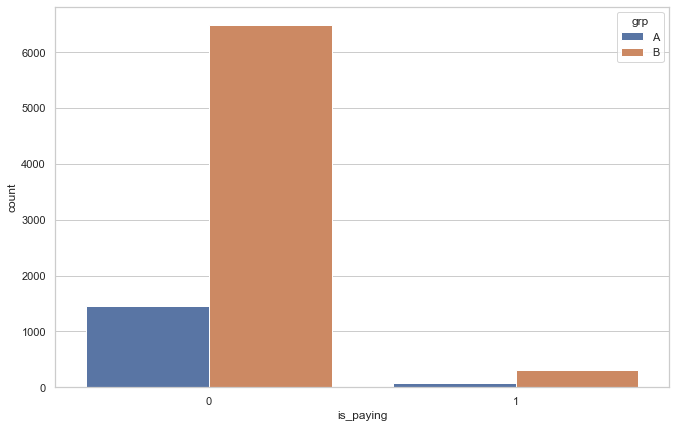

In [44]:
# для наглядности еще визуализируем данные
sns.countplot(data=active_data, x='is_paying', hue='grp')

Видим, что количество платящих пользователей в тестовой группе выросло 

Теперь проверим статистическую значимость результата с помощь хи-квадрат.

Сформулируем гипотезы:
<br>**H0** - эффекта от внедрения новой механики оплаты услуг на сайте нет, рост количества платящих пользователей обусловлен другими факторами
<br>**H1** - внедрение новой механики оплаты услуг на сайте привело к росту количества платящих пользователей

In [45]:
exp, obs, stats = pg.chi2_independence(data=active_data,
                                      x='grp',
                                      y='is_paying')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


Результаты:
- p-val>0.05, значит, средние в группах значимо не различаются, мы не можем отклонить нулевую гипотезу
- очень маленькое значение cramer (около 0), т.е. это показатель показывает на сколько сильно проявилось различие
<br>Вывод: никакого выраженного различия мы не видим.

Анализ среднего дохода на платящего пользователя (**ARPPU**)

Создадим датафрейм только с платящими пользователями. Для этого за основу возьмем датафрейм *data_revenue*.

In [46]:
data_paying_users = data_revenue.query('rev>0')
data_paying_users.head()

,grp,student_id,rev
0,A,1627,990.0
60,A,287008,1830.0
84,A,332387,2910.0
94,A,347455,2820.0
131,A,445767,3660.0


In [47]:
# посмотрим значения среднего дохода в контрольной и тестовой группах
data_paying_users.groupby('grp', as_index=False).agg({'rev' : 'mean'})

,grp,rev
0,A,933.589744
1,B,1257.878992


И здесь мы видим, что средний доход в тестовой группе больше.

Посмотрим описательные статистики по группам

In [48]:
# контрольная группа A
data_paying_users.query("grp == 'A'").rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [49]:
# тестовая группа B
data_paying_users.query("grp == 'B'").rev.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

C:\Users\Irina\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Irina\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Irina\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Irina\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='rev', ylabel='Count'>

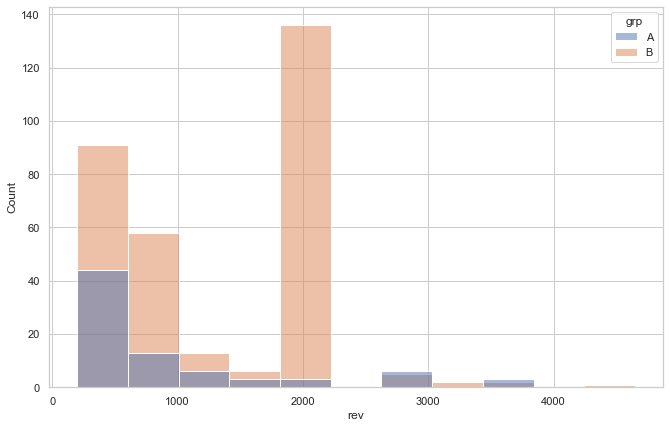

In [50]:
# визуализируем данные
sns.histplot(data=data_paying_users, x='rev', hue='grp')

Видим, что сильно выросло количество пользователей с доходом в 2000

Оценим статистическую значимость результата.
<br>Сформулируем гипотезы:
<br>**H0** - эффекта от внедрения новой механики оплаты услуг на сайте нет, изменение среднего дохода платящего пользователя обусловлено другими факторами
<br>**H1** - внедрение новой механики оплаты услуг на сайте привело к росту среднего дохода платящего пользователя

In [51]:
pg.ttest(x=data_paying_users.query("grp == 'A'")['rev'],
        y=data_paying_users.query("grp == 'B'")['rev'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


Результаты:
- p-val<0.05, что значит, что мы получили значимое различие средних в группах. 
- BF10=6,536. Это значит, что вероятность правоты альтернативной гипотезы равна 650%.
<br>Вывод: в результате эксперимента мы получили значимые различия, можем отклонить нулевую гипотезу.

In [52]:
# проверим еще статистическую значимость с помощье теста Манна-Уитни
pg.mwu(x=data_paying_users.query("grp == 'A'")['rev'],
        y=data_paying_users.query("grp == 'B'")['rev'])

,U-val,alternative,p-val,RBC,CLES
MWU,9001.0,two-sided,0.000251,0.264984,0.367508


Результаты:
- p-val<0.05, значит, средние в группах значимо различаются.
- CLES=37%, что значит, что 37% пользователей из контрольной группы имеют значения больше, чем пользователи в тестовой группе.
<br>Вывод: в результате эксперимента мы получили значимые различия, можем отклонить нулевую гипотезу.

**Общий вывод по эсперименту**
<br>Рекомендация по запуску новой механики оплаты услуг на сайте зависит от целевого показателя эксперимента.
<br>Если целевые показатели *рост среднего дохода на пользователя (ARPU)* и *рост количества платящих пользователей*, то тест не показал значимого эффекта, а изменения обусловлены другими факторами. А это значит, что лучше оставить действующую (старую) механику оплаты услуг на сайте.
<br>Если же целевой показатель *средний доход на платящего пользователя (ARPPU)*, то тест показал статистически значимые результаты, и мы можем внедрять новую механику оплаты услуг на сайте на всех пользователей.